# Homework 2:
## Bayes Optimal Classifiers

Reflection:
This assignment is aimed for developing Bayes optimial decision with conditional likelihoods (1) unequal variance-covariance matrices (2) equal variance-covariance matrices (3) equal shape matrices. The subtasks for each conditional likelihoods include equal class priors, bias priors and bias priors with cost.
The equal prior class is equal probability for the classes (in this case, we have two classes, yes and no)
When we put the bias (in our case is not not selecting the new bank service 0.9), we can see the increased "No" prediction, because we put more weight on not selecting service compared to selecting service.
The third scenario, we want to put the cost on 15 times the cost of classifying a customer is not new service. In fact, he/she is. It means that we want to reduce false negative. We shift the cutoff |ratio in the lower side, and we can get more "Yes" cases, becuase we want to reduce false negative. We get more labels on "Yes".
Basically, qda, lda, T-lda shows the same trends on equal prior, bias prior and bias prior + cost. I used "yellow" bold line to show the real response y. We can see equal prior is close to real response y. 

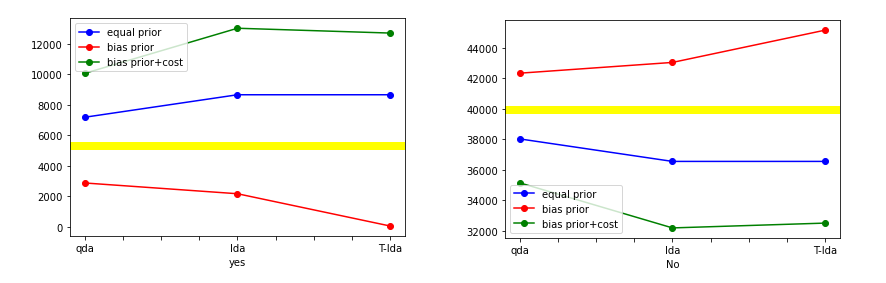

### 2. (30) The authors in [1] describe a marketing campaign by a bank in Portugal. Use the data (bank-full.csv) from this campaign with only the predictor variables age, balance, and duration and the response variable, y, to
### create Bayes optimal decision rules each of the following nine conditions:

In [1]:
## import data and create dataframe for three attributes 
import pandas as pd
import numpy as np
bank1 = pd.read_csv("bank-full.csv", sep=";")
bank1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [2]:
bank_s = bank1[['age', 'balance', 'duration', 'y']]
bank_s.drop(bank_s.columns[1], axis=1)
bank_s
#bank_s.to_csv("bank_s.csv")

,age,balance,duration,y
0,58,2143,261,no
1,44,29,151,no
2,33,2,76,no
3,47,1506,92,no
4,33,1,198,no
...,...,...,...,...
45206,51,825,977,yes
45207,71,1729,456,yes
45208,72,5715,1127,yes
45209,57,668,508,no


### (a) Assume Gaussian class conditional likelihoods with unequal variancecovariance matrices with each of the following additional assumptions applied singularly to each decision rule in this class:
<br>i. Equal class priors and equal costs for misclassification;
<br>ii. The prior for not selecting the new bank service is 0.9 and misclassification costs are equal; and
<br>iii. The prior for not selecting the new bank service is 0.9 and the
cost of classifying a customer as not a new service candidate
when they are is 15 times the cost of classifying a customer as a
new service customer

For the first question, I would like to use Quadratic Discriminant Analysis(QDA), the covariance matrix can be different for each class. We can estimate the covariance matrix separately for each class.  

In [3]:
# This is code for Quadratic Discriminant Analysis
# Written by William F Basener
# University of Virginia, School of Data Science
# For use in teaching Bayesian Machine Learning
#
# The code currently computes the maximum likelihood classification
# Student is to add method to compute posterior probabilities and maximum probability classification

import pandas as pd
import numpy as np


def multivariate_gaussian_pdf(X, MU, SIGMA):
    """Code from Data Blog https://xavierbourretsicotte.github.io/MLE_Multivariate_Gaussian.html
    Maximum Likelihood Estimator: Multivariate Gaussian Distribution
        by Xavier Bourret Sicotte, Fri 22 June 2018
    Returns the pdf of a multivariate Gaussian distribution
     - X, MU are p x 1 vectors
     - SIGMA is a p x p matrix"""
    # Initialize and reshape
    X = X.reshape(-1, 1)
    MU = MU.reshape(-1, 1)
    p, _ = SIGMA.shape

    # Compute values
    SIGMA_inv = np.linalg.inv(SIGMA)
    denominator = np.sqrt((2 * np.pi) ** p * np.linalg.det(SIGMA))
    exponent = -(1 / 2) * ((X - MU).T @ SIGMA_inv @ (X - MU))

    # Return result
    return float((1. / denominator) * np.exp(exponent))


class QDA:
    """Creates a class for Quadratic Discriminant Analysis
    Input:
        fname = file name for a csv file, must have one column labeled "class" and the rest numeric data
    Methods:
        compute_probabilities = given an input observation computes the likelihood for each class and the GML class
        compute_probabilities: given an input observation and prior probabilities,
            computes the posterior probabilities for each class and most probable class"""

    def __init__(self, fname):
        # reads the data and computes the statistics needed for classification

        # read the iris data as a Pandas data frame
        df = pd.read_csv(fname)

        # separate the class labels from the rest of the data
        # we are assuming the column name with class labels is 'Class'
        # and all other columns are numeric
        self.data_labels = df.loc[:]['y']
        self.data = np.asarray(df.drop('y', axis=1, inplace=False))

        # get information about the dimensions the data
        self.num_rows, self.num_cols = self.data.shape

        # get the class names as an array of strings
        self.class_names = np.unique(self.data_labels)

        # determine number of observations in each class
        self.num_obs = dict()
        for name in self.class_names:
            self.num_obs[name] = sum(self.data_labels == name)

        # compute the mean of each class
        self.means = dict()
        for name in self.class_names:
            self.means[name] = np.mean(self.data[self.data_labels == name, :], 0)

        # compute the covariance matrix of each class
        self.covs = dict()
        for name in self.class_names:
            self.covs[name] = np.cov(np.transpose(self.data[self.data_labels == name, :]))

    def compute_likelihoods(self, x):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.covs[name])
            idx = idx + 1
        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(likelihoods)[::-1]

        # print the predicted class and all class likelihoods
        print('QDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('QDA Class Likelihoods:')
        #for idx in range(len(indices_sorted)):
        #    print(self.class_names[indices_sorted[idx]] + ': ' + str(likelihoods[indices_sorted[idx]]))

        # return the likelihoods
        return likelihoods
    def compute_probabilities(self, x, priors):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.covs[name])
            idx = idx + 1
        # compute the probabilities
        # Step : Compute the denominator in Bayes Theorem
        denominator = 0
        idx = 0 
        for name in self.class_names:
            denominator = denominator + likelihoods[idx] * priors[name]
            idx = idx + 1
        # Step 2: Compute the probabilities 
        probabilities = np.zeros(len(self.class_names))
        idx = 0 
        for name in self.class_names:
            probabilities[idx] =likelihoods[idx]*priors[name]/denominator
            idx = idx + 1
        probabilities     
        
        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(probabilities)[::-1]

        # print the predicted class and all class likelihoods
        #print('QDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        #print('QDA Class Likelihoods:')
        #for idx in range(len(indices_sorted)):
        #     print(self.class_names[indices_sorted[idx]] + ': ' + str(probabilities[indices_sorted[idx]]))

        # return the likelihoods
        return probabilities 

In [4]:
model_qda = QDA('bank_s.csv')
bank_observation = [50, 335, 441]
model_qda.compute_likelihoods(bank_observation)

equal_priors = {
    "no": 1 / 2,
    "yes": 1 / 2,
}
model_qda.compute_probabilities(bank_observation, equal_priors)
print(model_qda)

QDA Predicted Class: no
QDA Class Likelihoods:


In [5]:
bank_s

,age,balance,duration,y
0,58,2143,261,no
1,44,29,151,no
2,33,2,76,no
3,47,1506,92,no
4,33,1,198,no
...,...,...,...,...
45206,51,825,977,yes
45207,71,1729,456,yes
45208,72,5715,1127,yes
45209,57,668,508,no


## Response 
## i. Equal class priors and equal costs for misclassification;

In [6]:
equal_priors = {
    "no" : 0.5,
    "yes": 0.5
    }
cost = [[0, 1], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_qda.compute_probabilities(newdata, equal_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_i = bank_s.copy()
bank_s_i['pred'] = categos
bank_s_i['costprob_yesno'] = costprob     

In [7]:
bank_s_i = bank_s.copy()
bank_s_i['pred'] = categos
bank_s_i['prob_yesNo'] = costprob

In [8]:
bank_s_i

,age,balance,duration,y,pred,prob_yesNo
0,58,2143,261,no,no,"[0.35763311062498676, 0.6423668893750132]"
1,44,29,151,no,no,"[0.17846555201693523, 0.8215344479830649]"
2,33,2,76,no,no,"[0.182357209648594, 0.817642790351406]"
3,47,1506,92,no,no,"[0.19294466706953375, 0.8070553329304663]"
4,33,1,198,no,no,"[0.19556491430280967, 0.8044350856971904]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[0.9945566560303954, 0.005443343969604524]"
45207,71,1729,456,yes,yes,"[0.8310826094770001, 0.16891739052299998]"
45208,72,5715,1127,yes,yes,"[0.9999456371904419, 5.436280955810343e-05]"
45209,57,668,508,no,yes,"[0.6180923222428371, 0.381907677757163]"


In [9]:
## analysis
bank_s_i["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [10]:
## analysis
bank_s_i["pred"].value_counts()

no     38028
yes     7183
Name: pred, dtype: int64

## Response ii
## ii. The prior for not selecting the new bank service is 0.9 and misclassification costs are equal

In [11]:
## Prior is biased. Need to put the biased number in.
biased_priors = {
    "no" : 0.9,
    "yes": 0.1
    }
cost = [[0, 1], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_qda.compute_probabilities(newdata, biased_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_a = bank_s.copy()
bank_s_a['pred'] = categos
bank_s_a['costprob_yesno'] = costprob   

In [12]:
bank_s_a

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,no,"[0.05825653862200507, 0.9417434613779948]"
1,44,29,151,no,no,"[0.023568285390619018, 0.976431714609381]"
2,33,2,76,no,no,"[0.02418164275947698, 0.9758183572405231]"
3,47,1506,92,no,no,"[0.02587623559629479, 0.9741237644037052]"
4,33,1,198,no,no,"[0.026301583256364804, 0.9736984167436352]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[0.9530542396457421, 0.04694576035425793]"
45207,71,1729,456,yes,no,"[0.353450763834594, 0.6465492361654059]"
45208,72,5715,1127,yes,yes,"[0.9995109474041621, 0.0004890525958378794]"
45209,57,668,508,no,no,"[0.15241738026577534, 0.8475826197342246]"


In [13]:
## analysis
bank_s_a["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [14]:
## analysis
bank_s_a["pred"].value_counts()

no     42343
yes     2868
Name: pred, dtype: int64

## Response
## iii. The prior for not selecting the new bank service is 0.9 and the cost of classifying a customer as not a new service candidate when they are is 15 times the cost of classifying a customer as a new service customer

In [15]:
## Construct the bias with bias, and construct the cost with 15x
biased_priors = {
    "no" : 0.9,
    "yes": 0.1
    }
cost = [[0, 15], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_qda.compute_probabilities(newdata, biased_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_aa = bank_s.copy()
bank_s_aa['pred'] = categos
bank_s_aa['costprob_yesno'] = costprob   

In [16]:
bank_s_aa

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,no,"[0.873848079330076, 0.9417434613779948]"
1,44,29,151,no,no,"[0.3535242808592853, 0.976431714609381]"
2,33,2,76,no,no,"[0.3627246413921547, 0.9758183572405231]"
3,47,1506,92,no,no,"[0.3881435339444218, 0.9741237644037052]"
4,33,1,198,no,no,"[0.3945237488454721, 0.9736984167436352]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[14.295813594686132, 0.04694576035425793]"
45207,71,1729,456,yes,yes,"[5.30176145751891, 0.6465492361654059]"
45208,72,5715,1127,yes,yes,"[14.992664211062433, 0.0004890525958378794]"
45209,57,668,508,no,yes,"[2.2862607039866303, 0.8475826197342246]"


In [17]:
## analysis
bank_s_aa["pred"].value_counts()

no     35143
yes    10068
Name: pred, dtype: int64

### (b) Assume Gaussian class conditional likelihoods with equal variancecovariance matrices with each of the following additional assumptions applied singularly to each decision rule in this class:
<br>i. Equal class priors and equal costs for misclassification;
<br>ii. The prior for not selecting the new bank service is 0.9 and misclassification costs are equal; and
<br>iii. The prior for not selecting the new bank service is 0.9 and the
cost of classifying a customer as not a new service candidate
when they are is 15 times the cost of classifying a customer as a
new service customer

For this question, I used LDA. LDA assumes for different k that the covariance matrix is identical. The classifier becomes liner. Since the covariance matrix determines the shape of the Gaussian density, in LDA, the Gaussian densities for different class have the same shape. 

In [18]:
import pandas as pd
import numpy as np

In [19]:
def multivariate_gaussian_pdf(X, MU, SIGMA):
    """Code from Data Blog https://xavierbourretsicotte.github.io/MLE_Multivariate_Gaussian.html
    Maximum Likelihood Estimator: Multivariate Gaussian Distribution
        by Xavier Bourret Sicotte, Fri 22 June 2018
    Returns the pdf of a multivariate Gaussian distribution
     - X, MU are p x 1 vectors
     - SIGMA is a p x p matrix"""
    # Initialize and reshape
    X = X.reshape(-1, 1)
    MU = MU.reshape(-1, 1)
    p, _ = SIGMA.shape

    # Compute values
    SIGMA_inv = np.linalg.inv(SIGMA)
    denominator = np.sqrt((2 * np.pi) ** p * np.linalg.det(SIGMA))
    exponent = -(1 / 2) * ((X - MU).T @ SIGMA_inv @ (X - MU))

    # Return result
    return float((1. / denominator) * np.exp(exponent))

In [20]:
class LDA:
    """Creates a class for Linear Discriminant Analysis
    Input:
        fname = file name for a csv file, must have one column labeled "class" and the rest numeric data
    Methods:
        compute_probabilities = given an input observation computes the likelihood for each class and the GML class
        compute_probabilities: given an input observation and prior probabilities,
            computes the posterior probabilities for each class and most probable class"""

    def __init__(self, fname):
        # reads the data and computes the statistics needed for classification

        # read the iris data as a Pandas data frame
        df = pd.read_csv(fname)

        # separate the class labels from the rest of the data
        # we are assuming the column name with class labels is 'Class'
        # and all other columns are numeric
        self.data_labels = df.loc[:]['y']
        self.data = np.asarray(df.drop('y', axis=1, inplace=False))

        # get information about the dimensions the data
        self.num_rows, self.num_cols = self.data.shape

        # get the class names as an array of strings
        self.class_names = np.unique(self.data_labels)

        # determine number of observations in each class
        self.num_obs = dict()
        for name in self.class_names:
            self.num_obs[name] = sum(self.data_labels == name)

        # compute the mean of each class
        self.means = dict()
        for name in self.class_names:
            self.means[name] = np.mean(self.data[self.data_labels == name, :], 0)

        # compute the mean covariance matrix
        self.cov = np.zeros([self.num_cols, self.num_cols])
        for name in self.class_names:
            self.cov = self.cov + self.num_obs[name] * np.cov(np.transpose(self.data[self.data_labels == name, :]))
        self.cov = self.cov / self.num_rows

    def compute_likelihoods(self, x):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.cov)
            idx = idx + 1

        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(likelihoods)[::-1]

        # print the predicted class and all class likelihoods
        print('LDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('LDA Class Likelihoods:')
        for idx in range(len(indices_sorted)):
            print(self.class_names[indices_sorted[idx]] + ': ' + str(likelihoods[indices_sorted[idx]]))

        # return the likelihoods
        return likelihoods

    def compute_probabilities(self, x, priors):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.cov)
            idx = idx + 1
        # compute the probabilities
        # Step : Compute the denominator in Bayes Theorem
        denominator = 0
        idx = 0 
        for name in self.class_names:
            denominator = denominator + likelihoods[idx] * priors[name]
            idx = idx + 1
        # Step 2: Compute the probabilities 
        probabilities = np.zeros(len(self.class_names))
        idx = 0 
        for name in self.class_names:
            probabilities[idx] =likelihoods[idx]*priors[name]/denominator
            idx = idx + 1
        probabilities     
        
        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(probabilities)[::-1]

        # print the predicted class and all class likelihoods
        #print('LDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        #print('LDA Class Likelihoods:')
        #for idx in range(len(indices_sorted)):
        #    print(self.class_names[indices_sorted[idx]] + ': ' + str(probabilities[indices_sorted[idx]]))

        # return the likelihoods
        return probabilities 

In [21]:
model_lda = LDA('bank_s.csv')
bank_observation = [50, 335, 441]
model_lda.compute_likelihoods(bank_observation)

uninformative_priors = {
    "no": 1 / 2,
    "yes": 1 / 2,
}
model_lda.compute_probabilities(bank_observation, uninformative_priors)
print(model_lda)

LDA Predicted Class: yes
LDA Class Likelihoods:
yes: 4.853375958249796e-09
no: 3.398861338607558e-09


### (c) Assume multivariate t distributions for the class conditional likelihoods with equal shape (precision) matrices with each of the following additional assumptions applied singularly to each decision rule in
this class:
<br>i. Equal class priors and equal costs for misclassification;
<br>ii. The prior for not selecting the new bank service is 0.9 and misclassification costs are equal; and
<br>iii. The prior for not selecting the new bank service is 0.9 and the
cost of classifying a customer as not a new service candidate
when they are is 15 times the cost of classifying a customer as a
new service customer
Show your resulting decision rules for each of these cases.

For this question, I used t distribution. (https://en.wikipedia.org/wiki/Multivariate_t-distribution)
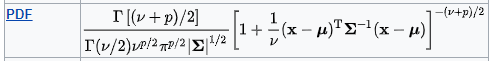

## Response:
## i Equal class priors and equal costs for misclassification;

In [22]:
equal_priors = {
    "no" : 0.5,
    "yes": 0.5
    }
cost = [[0, 1], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_lda.compute_probabilities(newdata, equal_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_ib = bank_s.copy()
bank_s_ib['pred'] = categos
bank_s_ib['costprob_yesno'] = costprob  

In [23]:
bank_s_ib

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,no,"[0.3764460723991164, 0.6235539276008835]"
1,44,29,151,no,no,"[0.20658612735834614, 0.7934138726416538]"
2,33,2,76,no,no,"[0.13490220938417083, 0.8650977906158291]"
3,47,1506,92,no,no,"[0.17085262014505803, 0.829147379854942]"
4,33,1,198,no,no,"[0.2370255869287188, 0.7629744130712811]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[0.9682495564290796, 0.031750443570920425]"
45207,71,1729,456,yes,yes,"[0.663597190353103, 0.3364028096468969]"
45208,72,5715,1127,yes,yes,"[0.9908259061782032, 0.009174093821796719]"
45209,57,668,508,no,yes,"[0.691578178315052, 0.308421821684948]"


In [24]:
## analysis
bank_s_ib["pred"].value_counts()

no     36559
yes     8652
Name: pred, dtype: int64

## Response 
## ii The prior for not selecting the new bank service is 0.9 and misclassification costs are equal

In [25]:
## construct bias prior
biased_priors = {
    "no" : 0.9,
    "yes": 0.1
    }
cost = [[0, 1], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_lda.compute_probabilities(newdata, biased_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_b = bank_s.copy()
bank_s_b['pred'] = categos
bank_s_b['costprob_yesno'] = costprob   

In [26]:
bank_s_b

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,no,"[0.06286221648813378, 0.9371377835118663]"
1,44,29,151,no,no,"[0.028117242878221392, 0.9718827571217786]"
2,33,2,76,no,no,"[0.017031424908576866, 0.9829685750914232]"
3,47,1506,92,no,no,"[0.022382891751355088, 0.9776171082486449]"
4,33,1,198,no,no,"[0.03336604966309033, 0.9666339503369097]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[0.7721266479151965, 0.2278733520848035]"
45207,71,1729,456,yes,no,"[0.17977707777206153, 0.8202229222279386]"
45208,72,5715,1127,yes,yes,"[0.9230786267636064, 0.07692137323639353]"
45209,57,668,508,no,no,"[0.1994529762099047, 0.8005470237900952]"


In [27]:
## analysis
bank_s_b["pred"].value_counts()

no     43046
yes     2165
Name: pred, dtype: int64

## Response
## iii The prior for not selecting the new bank service is 0.9 and the cost of classifying a customer as not a new service candidate when they are is 15 times the cost of classifying a customer as a new service customer

In [28]:
biased_priors = {
    "no" : 0.9,
    "yes": 0.1
    }
cost = [[0, 1], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_lda.compute_probabilities(newdata, biased_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_bb = bank_s.copy()
bank_s_bb['pred'] = categos
bank_s_bb['costprob_yesno'] = costprob   

In [29]:
bank_s_bb

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,no,"[0.06286221648813378, 0.9371377835118663]"
1,44,29,151,no,no,"[0.028117242878221392, 0.9718827571217786]"
2,33,2,76,no,no,"[0.017031424908576866, 0.9829685750914232]"
3,47,1506,92,no,no,"[0.022382891751355088, 0.9776171082486449]"
4,33,1,198,no,no,"[0.03336604966309033, 0.9666339503369097]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[0.7721266479151965, 0.2278733520848035]"
45207,71,1729,456,yes,no,"[0.17977707777206153, 0.8202229222279386]"
45208,72,5715,1127,yes,yes,"[0.9230786267636064, 0.07692137323639353]"
45209,57,668,508,no,no,"[0.1994529762099047, 0.8005470237900952]"


In [30]:
## analysis
bank_s_bb["pred"].value_counts()

no     43046
yes     2165
Name: pred, dtype: int64

## Response 
## iii. The prior for not selecting the new bank service is 0.9 and the cost of classifying a customer as not a new service candidate when they are is 15 times the cost of classifying a customer as a new service customer

In [31]:
biased_priors = {
    "no" : 0.9,
    "yes": 0.1
    }

cost = [[0, 15], [1, 0]]
costprob = []
cates = []

for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_lda.compute_probabilities(newdata, biased_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        cate = 'yes'
    else:
        cate = 'no'
    costprob.append(costout)
    cates.append(cate)
bank_s_aa = bank_s.copy()
bank_s_aa['pred'] = cates
bank_s_aa['costprob_yesno'] = costprob                        

In [32]:
bank_s_aa

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,yes,"[0.9429332473220067, 0.9371377835118663]"
1,44,29,151,no,no,"[0.4217586431733209, 0.9718827571217786]"
2,33,2,76,no,no,"[0.255471373628653, 0.9829685750914232]"
3,47,1506,92,no,no,"[0.3357433762703263, 0.9776171082486449]"
4,33,1,198,no,no,"[0.5004907449463549, 0.9666339503369097]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[11.581899718727946, 0.2278733520848035]"
45207,71,1729,456,yes,yes,"[2.696656166580923, 0.8202229222279386]"
45208,72,5715,1127,yes,yes,"[13.846179401454096, 0.07692137323639353]"
45209,57,668,508,no,yes,"[2.9917946431485705, 0.8005470237900952]"


In [33]:
## analysis
bank_s_aa["pred"].value_counts()

no     32200
yes    13011
Name: pred, dtype: int64

## (c)Assume multivariate t distributions for the class conditional likelihoods with equal shape (precision) matrices with each of the following additional assumptions applied singularly to each decision rule in
## this class:
i. Equal class priors and equal costs for misclassification;
ii. The prior for not selecting the new bank service is 0.9 and misclassification costs are equal; and
iii. The prior for not selecting the new bank service is 0.9 and the
cost of classifying a customer as not a new service candidate
when they are is 15 times the cost of classifying a customer as a

### df determination 
The particular form of the t distribution is determined by its degrees of freedom. The degrees of freedom refers to the number of independent observations in a set of data. When estimating a mean score or a proportion from a single sample, the number of independent observations is equal to the sample size minus one.

By denifition: t disteribution is determined by its degrees of freedom The degrees of freedom refers to the number of the independent observations in a set of data. 
When to use the t-distribution? (https://stattrek.com/probability-distributions/t-distribution.aspx#:~:text=The%20particular%20form%20of%20the,the%20sample%20size%20minus%20one.)

You must use the t-distribution table when working problems when the population standard deviation (σ) is not known and the sample size is small (n<30).

What is Most Common Practice:
Since people often prefer to use the normal, and since the t-distribution becomes equivalent to the normal when the number of cases becomes large, common practice often is:
<br>•	If σ known, then use normal.
<br>•	If σ not known:
<br>o	If n is large, then use normal.
<br>o	If n is small, then use t-distribution.

In [34]:
from math import *
def multivariate_t_pdf(x,mu,Sigma,df):
    '''
    Multivariate t-student density:
    output:
        the density of the given element
    input:
        x = parameter (d dimensional numpy array or scalar)
        mu = mean (d dimensional numpy array or scalar)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
    '''
    d = len(x)
    Num = gamma(1. * (d+df)/2)
    Denom = ( gamma(1.*df/2) * pow(df*pi,1.*d/2) * pow(np.linalg.det(Sigma),1./2) * pow(1 + (1./df)*np.dot(np.dot((x - mu),np.linalg.inv(Sigma)), (x - mu)),1.* (d+df)/2))
    result = 1. * Num / Denom
    return result

In [71]:
class LDA:
    """Creates a class for Linear Discriminant Analysis
    Input:
        fname = file name for a csv file, must have one column labeled "class" and the rest numeric data
    Methods:
        compute_probabilities = given an input observation computes the likelihood for each class and the GML class
        compute_probabilities: given an input observation and prior probabilities,
            computes the posterior probabilities for each class and most probable class"""

    def __init__(self, fname):
        # reads the data and computes the statistics needed for classification

        # read the iris data as a Pandas data frame
        df = pd.read_csv(fname)

        # separate the class labels from the rest of the data
        # we are assuming the column name with class labels is 'Class'
        # and all other columns are numeric
        self.data_labels = df.loc[:]['y']
        self.data = np.asarray(df.drop('y', axis=1, inplace=False))

        # get information about the dimensions the data
        self.num_rows, self.num_cols = self.data.shape

        # get the class names as an array of strings
        self.class_names = np.unique(self.data_labels)

        # determine number of observations in each class
        self.num_obs = dict()
        for name in self.class_names:
            self.num_obs[name] = sum(self.data_labels == name)

        # compute the mean of each class
        self.means = dict()
        for name in self.class_names:
            self.means[name] = np.mean(self.data[self.data_labels == name, :], 0)

        # compute the mean covariance matrix
        self.cov = np.zeros([self.num_cols, self.num_cols])
        for name in self.class_names:
            self.cov = self.cov + self.num_obs[name] * np.cov(np.transpose(self.data[self.data_labels == name, :]))
        self.cov = self.cov / self.num_rows
        
        #precision matrix
        self.precision = np.linalg.inv(self.cov)
        # self.def = self.num_cols - 1
        # dimension, length of x
        self.d =self.num_cols

    def compute_likelihoods(self, x):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_t_pdf(x, self.means[name], self.cov, self.d)
            idx = idx + 1

        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(likelihoods)[::-1]

        # print the predicted class and all class likelihoods
        print('LDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('LDA Class Likelihoods:')
        for idx in range(len(indices_sorted)):
            print(self.class_names[indices_sorted[idx]] + ': ' + str(likelihoods[indices_sorted[idx]]))

        # return the likelihoods
        return likelihoods

    def compute_probabilities(self, x, priors):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_t_pdf(x, self.means[name], self.cov, self.d)
            idx = idx + 1
        # compute the probabilities
        # Step : Compute the denominator in Bayes Theorem
        denominator = 0
        idx = 0 
        for name in self.class_names:
            denominator = denominator + likelihoods[idx] * priors[name]
            idx = idx + 1
        # Step 2: Compute the probabilities 
        probabilities = np.zeros(len(self.class_names))
        idx = 0 
        for name in self.class_names:
            probabilities[idx] =likelihoods[idx]*priors[name]/denominator
            idx = idx + 1
        probabilities     
        
        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(probabilities)[::-1]

        # print the predicted class and all class likelihoods
        #print('LDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        #print('LDA Class Likelihoods:')
        #for idx in range(len(indices_sorted)):
        #    print(self.class_names[indices_sorted[idx]] + ': ' + str(probabilities[indices_sorted[idx]]))

        # return the likelihoods
        return probabilities 

## i. Equal class priors and equal costs for misclassification

In [72]:
model_lda = LDA('bank_s.csv')
## degree of freedome is sample size -1
equal_priors = {
    "no": 1 / 2,
    "yes": 1 / 2,
}

In [73]:
equal_priors = {
    "no" : 0.5,
    "yes": 0.5
    }
cost = [[0, 1], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_lda.compute_probabilities(newdata, equal_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_c = bank_s.copy()
bank_s_c['pred'] = categos
bank_s_c['costprob_yesno'] = costprob  

In [74]:
bank_s_c

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,no,"[0.3794569832454973, 0.6205430167545026]"
1,44,29,151,no,no,"[0.146953283449371, 0.853046716550629]"
2,33,2,76,no,no,"[0.12471878700408325, 0.8752812129959168]"
3,47,1506,92,no,no,"[0.13236655774624254, 0.8676334422537575]"
4,33,1,198,no,no,"[0.1863767891971951, 0.813623210802805]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[0.8758060842822187, 0.12419391571778121]"
45207,71,1729,456,yes,yes,"[0.5878839850077949, 0.41211601499220507]"
45208,72,5715,1127,yes,yes,"[0.772449858083205, 0.22755014191679493]"
45209,57,668,508,no,yes,"[0.6878206852884794, 0.3121793147115206]"


In [75]:
## analysis
bank_s_c["pred"].value_counts()

no     36559
yes     8652
Name: pred, dtype: int64

## ii. The prior for not selecting the new bank service is 0.9 and misclassification costs are equal

In [76]:
biased_priors = {
    "no" : 0.9,
    "yes": 0.1
    }
cost = [[0, 1], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_lda.compute_probabilities(newdata, biased_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_cc = bank_s.copy()
bank_s_cc['pred'] = categos
bank_s_cc['costprob_yesno'] = costprob   

In [77]:
bank_s_cc

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,no,"[0.06362090696277815, 0.9363790930372219]"
1,44,29,151,no,no,"[0.01878147548611548, 0.9812185245138846]"
2,33,2,76,no,no,"[0.01558546554005313, 0.9844145344599469]"
3,47,1506,92,no,no,"[0.016668609996368162, 0.9833313900036319]"
4,33,1,198,no,no,"[0.02482050132738926, 0.9751794986726108]"
...,...,...,...,...,...,...
45206,51,825,977,yes,no,"[0.4393195564985687, 0.5606804435014314]"
45207,71,1729,456,yes,no,"[0.13681494514186257, 0.8631850548581375]"
45208,72,5715,1127,yes,no,"[0.273879430980881, 0.7261205690191191]"
45209,57,668,508,no,no,"[0.19666434977097105, 0.803335650229029]"


In [78]:
## analysis
bank_s_cc["pred"].value_counts()

no     45155
yes       56
Name: pred, dtype: int64

## iii. The prior for not selecting the new bank service is 0.9 and the cost of classifying a customer as not a new service candidate when they are is 15 times the cost of classifying a customer as a new service customer

In [79]:
biased_priors = {
    "no" : 0.9,
    "yes": 0.1
    }

cost = [[0, 15], [1, 0]]
costprob = []
categos = []
for idx, row in bank_s.iterrows():
    newdata = [row['age'], row['balance'], row['duration']]
    output = model_lda.compute_probabilities(newdata, biased_priors)
    costout = np.matmul(cost, output)
    if costout[0] > costout[1]:
        catego = 'yes'
    else:
        catego = 'no'
    costprob.append(costout)
    categos.append(catego)
bank_s_ccc = bank_s.copy()
bank_s_ccc['pred'] = categos
bank_s_ccc['costprob_yesno'] = costprob  

In [80]:
bank_s_ccc

,age,balance,duration,y,pred,costprob_yesno
0,58,2143,261,no,yes,"[0.9543136044416723, 0.9363790930372219]"
1,44,29,151,no,no,"[0.2817221322917322, 0.9812185245138846]"
2,33,2,76,no,no,"[0.23378198310079695, 0.9844145344599469]"
3,47,1506,92,no,no,"[0.25002914994552244, 0.9833313900036319]"
4,33,1,198,no,no,"[0.3723075199108389, 0.9751794986726108]"
...,...,...,...,...,...,...
45206,51,825,977,yes,yes,"[6.589793347478531, 0.5606804435014314]"
45207,71,1729,456,yes,yes,"[2.0522241771279384, 0.8631850548581375]"
45208,72,5715,1127,yes,yes,"[4.108191464713215, 0.7261205690191191]"
45209,57,668,508,no,yes,"[2.949965246564566, 0.803335650229029]"


In [81]:
## analysis
bank_s_ccc["pred"].value_counts()

no     32515
yes    12696
Name: pred, dtype: int64

In [86]:
## Yes Table 
# intialise data of lists.
import matplotlib.pyplot as plt
yesdata = {'yes':['qda', 'lda', 'T-lda' ],
        'equal prior':[7183, 8652, 8652],
        'bias prior':[2868, 2165, 56],
        'bias prior+cost':[10068, 13011, 12696],}
 
# Create DataFrame
df1 = pd.DataFrame(yesdata)
 
# Print the output.
print(df1)

     yes  equal prior  bias prior  bias prior+cost
0    qda         7183        2868            10068
1    lda         8652        2165            13011
2  T-lda         8652          56            12696


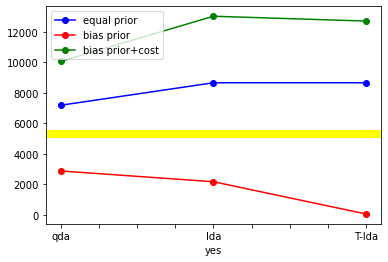

In [87]:
import matplotlib.pyplot as plt
ax = plt.gca()
df1.plot(kind='line',x='yes',y='equal prior',marker='o', color='b', ax=ax)
df1.plot(kind='line',x='yes',y='bias prior', marker='o', color='r', ax=ax)
df1.plot(kind='line',x='yes',y='bias prior+cost', marker='o', color='g', ax=ax)
# Draw a default hline at y=1 that spans the xrange
plt.axhline(y=5289, linewidth=8, color='yellow')

In [88]:
## No table
## Yes Table 
# intialise data of lists.
nodata = {'No':['qda', 'lda', 'T-lda' ],
        'equal prior':[38028, 36559, 36559],
        'bias prior':[42343, 43046, 45155],
        'bias prior+cost':[35143, 32200, 32515],}
 
# Create DataFrame
df_n = pd.DataFrame(nodata)
 
# Print the output.
print(df_n)

      No  equal prior  bias prior  bias prior+cost
0    qda        38028       42343            35143
1    lda        36559       43046            32200
2  T-lda        36559       45155            32515


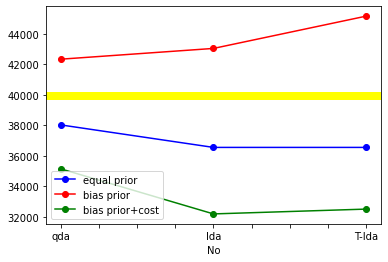

In [89]:
ax = plt.gca()
df_n.plot(kind='line',x='No',y='equal prior',marker='o', color='b', ax=ax)
df_n.plot(kind='line',x='No',y='bias prior', marker='o', color='r', ax=ax)
df_n.plot(kind='line',x='No',y='bias prior+cost', marker='o', color='g', ax=ax)
plt.axhline(y=39922, linewidth=8, color='yellow')